In [78]:
import warnings
import glob
import matplotlib.pyplot as plt
from src.experiment_logging.log_analyzer import LogAnalyzer
from src.experiment_logging.experiment_log import *
from src.datetime import get_current_timestamp

import plotly.tools


%load_ext autoreload
%autoreload 2

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
from src.experiment_logging.log_analyzer import DONT_SHOW
from matplotlib.patches import Patch

# plt.close('all')

la = LogAnalyzer()
la.load_log_folder(
    'experiment_logs/HalfCheetah-v4/sac/',
    log_filter=lambda log: '__default' in log['logs_by_category']
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Courier New"]
fig: plt.Figure
ax: plt.Axes
fig, ax = plt.subplots(figsize=(12, 11))

fig.text(.8, .95, get_current_timestamp())

def get_log_group(log: ExperimentLog):
    if 'Debug' in log['experiment_tags']:
        values = {
            'Debug': ', '.join(
                []
                + (['policy'] if len(log['hyper_parameters']['policy']) == 0 else [])
                + (['buffer'] if len(log['hyper_parameters']['buffer']) == 0 else [])
            ),
        }
    else:
        values = {
            'reward_scale': log['hyper_parameters']['buffer']['reward_scale'],
            'num_envs': f"{log['hyper_parameters']['num_envs']:3d}",
            'buffer_step_size': f"{log['hyper_parameters']['buffer']['step_size']:7d}",
            'entropy_coef_optimization': log['hyper_parameters']['entropy_coef'] == 'dynamic',
            'warmup_steps': log['hyper_parameters']['warmup_steps'],
            # 'truncated != done': 'consider_truncated_as_done' in log['hyper_parameters']['buffer'] and not  log['hyper_parameters']['buffer']['consider_truncated_as_done']
        }
        
    return ', '.join([f'{k}: {v}' for k, v in values.items()])

ax.grid()
ax.set(xlabel='num_gradient_steps', ylabel='score mean')
la.plot_logs_grouped(
    lambda item: item['num_gradient_steps'] if item['num_gradient_steps'] > 0 else item['step'] - 10_000, # warmup_steps 
    lambda item: item['scores']['mean'] if item['scores'] is not None else 0 ,
    get_log_group=get_log_group,
    filter_log=lambda log: log['hyper_parameters']['warmup_steps'] == 10000 and 'Debug' not in log['experiment_tags'], #  and log['logs_by_category']['__default'][-1]['step'] > 1e6,
    ax=ax,
    plot_individual=True,
    # mean_plot_kwargs={
    #     'linewidth': 0.0,
    #     'moving_average_window_size': 20,
    #     'moving_average_plot_kwargs': {
    #         'linewidth': 0.0
    #     }
    # },
    mean_plot_kwargs=DONT_SHOW,
    fill_plot_kwargs=DONT_SHOW,
    individual_plot_kwargs={
        'linewidth': 0.5, 
    },
    latest_individual_plot_kwargs={
        'linewidth': 0.99,
        # 'marker': 'o',
        # 'markevery': 5,
        # # 'fillstyle': 'none'
    },
    latest_n_individual_plots=2,
)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.10, box.width, box.height * 0.90])
# 
# handles, labels = plt.gca().get_legend_handles_labels()
# 
# new_handles = [
#     Patch(facecolor=handle.get_color(), label=label)
#     for handle, label in zip(handles, labels, strict=True)
# ]
# 
# ax.legend(handles=new_handles, 
#            handlelength=0.8, handleheight=0.8, loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           ncol=1, fancybox=True, shadow=True)
# fig.show()

from collections import defaultdict
from matplotlib.lines import Line2D
import re
import matplotlib.pyplot as plt
# 
# fig, ax = plt.subplots(figsize=(12, 8))
line2d: Optional[Line2D] = None

entries_by_label: defaultdict[str, list[list[dict]]] = defaultdict(lambda: [])

for data_file in glob.glob('experiment_logs/HalfCheetah-v4/sac_sb3/*.txt'):

    # Initialize variables
    entries = []
    current_entry = {}
    in_entry = False

    with open(data_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('---'):
                # Toggle the in_entry flag
                if in_entry:
                    # We're ending an entry
                    entries.append(current_entry)
                    current_entry = {}
                in_entry = not in_entry
            elif in_entry:
                # We're inside an entry
                if line.startswith('|'):
                    # Remove leading and trailing '|', then split by '|'
                    parts = [part.strip() for part in line.strip('|').split('|')]
                    if len(parts) >= 2:
                        key = parts[0]
                        value = parts[1]
                        if key == 'total_timesteps':
                            current_entry['total_timesteps'] = int(value)
                        if key == 'n_updates':
                            current_entry['n_updates'] = int(value)
                        elif key == 'ep_rew_mean':
                            current_entry['ep_rew_mean'] = float(value)

    # # Print the extracted data
    # for idx, entry in enumerate(entries, start=1):
    #     n_updates = entry.get('n_updates', 'N/A')
    #     ep_rew_mean = entry.get('ep_rew_mean', 'N/A')
    #     print(f"Entry {idx}: n_updates = {n_updates}, ep_rew_mean = {ep_rew_mean}")
    
    label = f'[sb3] num_envs = {16 if "envs=16" in data_file else 1}'

    has_reward_scale = "reward_scale=5" in data_file
    label += f', reward_scale = {5 if has_reward_scale else 1}'
    
    label += f', learning_starts = {10000 if "learning_starts=10000" in data_file else 100}'
    
    label += f', sws = {1 if "sws=1" in data_file else 100}'
    
    label += ', debug' if 'debug' in data_file else ''
    
    # label += f', seed = {None if "seed=594371" not in data_file else 594371}'
    
    entries = [entry for entry in entries if 'n_updates' in entry and entry['n_updates'] < 1_500_000]
    
    if 'envs=16' in data_file or 'seed' in data_file:
        continue
    
    if 'learning_starts = 10000' not in label or 'sws = 100' in label:
        continue
    
    entries_by_label[label].append(entries)
    

for label, entries_list in sorted(entries_by_label.items(), key=lambda le: le[0]):
    plot_kwargs = {
        'linewidth': 0.99
    }
    full_label = f'({len(entries_list)}x) {label}'
    line2d = ax.plot(
        [entry['n_updates'] if 'n_updates' in entry else 0 for entry in entries_list[0]],
        [entry['ep_rew_mean'] / (5 if 'reward_scale = 5' in label else 1) for entry in entries_list[0]],
        label=full_label,
        **plot_kwargs
    )[0]
    for entries in entries_list[1:]:
        ax.plot(
            [entry['n_updates'] if 'n_updates' in entry else 0 for entry in entries],
            [entry['ep_rew_mean'] / (5 if 'reward_scale = 5' in label else 1) for entry in entries],
            color=line2d.get_color(),
            label=full_label,
            **plot_kwargs
        )


ax.set_xticks([_ * 250000 for _ in range(7)])
ax.grid(True)
ax.legend()


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.10, box.width, box.height * 0.90])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), 
           handlelength=0.8, handleheight=0.8, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=1, fancybox=True, shadow=True, numpoints=1)

with warnings.catch_warnings(action='ignore'):
    pltly = plotly.tools.mpl_to_plotly(fig)
pltly

<IPython.core.display.Javascript object>

In [46]:
from matplotlib.patches import Patch
la = LogAnalyzer()
la.load_log_folder(
    'experiment_logs/HalfCheetah-v4/sac/',
    log_filter=lambda log: '__default' in log['logs_by_category']
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Courier New"]
fig: plt.Figure
ax: plt.Axes
fig, ax = plt.subplots(figsize=(12, 11))

fig.text(.8, .95, get_current_timestamp())

def get_log_group(log: ExperimentLog):
    values = {
        'reward_scale': log['hyper_parameters']['buffer']['reward_scale'],
        'num_envs': f"{log['hyper_parameters']['num_envs']:3d}",
        'buffer_step_size': f"{log['hyper_parameters']['buffer']['step_size']:7d}",
        'entropy_coef_optimization': log['hyper_parameters']['entropy_coef'] == 'dynamic',
        'warmup_steps': log['hyper_parameters']['warmup_steps'],
    }
    
    return ', '.join([f'{k}: {v}' for k, v in values.items()])

ax.grid()
ax.set(xlabel='num_gradient_steps', ylabel='entropy_coef mean')
la.plot_logs_grouped(
    lambda item: item['num_gradient_steps'], 
    lambda item: item['entropy_coef']['mean'] if item['entropy_coef'] is not None else 0 ,
    get_log_group=get_log_group,
    filter_log=lambda log: log['hyper_parameters']['warmup_steps'] == 10000, #  and log['logs_by_category']['__default'][-1]['step'] > 1e6,
    ax=ax,
    plot_individual=True,
    mean_plot_kwargs={
        'linewidth': 0.0,
        'moving_average_window_size': 20,
        'moving_average_plot_kwargs': {
            'linewidth': 0.0
        }
    },
    fill_plot_kwargs={'alpha': 0},
    individual_plot_kwargs={
        'linewidth': 0.5, 
    },
    latest_individual_plot_kwargs={
        'linewidth': 0.7,
        'marker': 'o',
        'markevery': 5,
        # 'fillstyle': 'none'
    }
)
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height * 0.10, box.width, box.height * 0.90])
# 
# handles, labels = plt.gca().get_legend_handles_labels()
# 
# new_handles = [
#     Patch(facecolor=handle.get_color(), label=label)
#     for handle, label in zip(handles, labels, strict=True)
# ]
# 
# ax.legend(handles=new_handles, 
#            handlelength=0.8, handleheight=0.8, loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           ncol=1, fancybox=True, shadow=True)
# fig.show()

from collections import defaultdict
from matplotlib.lines import Line2D
import re
import matplotlib.pyplot as plt
# 
# fig, ax = plt.subplots(figsize=(12, 8))
line2d: Optional[Line2D] = None

entries_by_label: defaultdict[str, list[list[dict]]] = defaultdict(lambda: [])

for data_file in glob.glob('experiment_logs/HalfCheetah-v4/sac_sb3/*.txt'):

    # Initialize variables
    entries = []
    current_entry = {}
    in_entry = False

    with open(data_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('---'):
                # Toggle the in_entry flag
                if in_entry:
                    # We're ending an entry
                    entries.append(current_entry)
                    current_entry = {}
                in_entry = not in_entry
            elif in_entry:
                # We're inside an entry
                if line.startswith('|'):
                    # Remove leading and trailing '|', then split by '|'
                    parts = [part.strip() for part in line.strip('|').split('|')]
                    if len(parts) >= 2:
                        key = parts[0]
                        value = parts[1]
                        if key == 'total_timesteps':
                            current_entry['total_timesteps'] = int(value)
                        elif key == 'n_updates':
                            current_entry['n_updates'] = int(value)
                        elif key == 'ep_rew_mean':
                            current_entry['ep_rew_mean'] = float(value)
                        elif key == 'ent_coef':
                            current_entry['ent_coef'] = float(value)

    # # Print the extracted data
    # for idx, entry in enumerate(entries, start=1):
    #     n_updates = entry.get('n_updates', 'N/A')
    #     ep_rew_mean = entry.get('ep_rew_mean', 'N/A')
    #     print(f"Entry {idx}: n_updates = {n_updates}, ep_rew_mean = {ep_rew_mean}")
    
    label = f'[sb3] num_envs = {16 if "envs=16" in data_file else 1}'

    has_reward_scale = "reward_scale=5" in data_file
    label += f', reward_scale = {5 if has_reward_scale else 1}'
    
    label += f', learning_starts = {10000 if "learning_starts=10000" in data_file else 100}'
    
    label += f', sws = {1 if "sws=1" in data_file else 100}'
    
    # label += f', seed = {None if "seed=594371" not in data_file else 594371}'
    
    entries = [entry for entry in entries if 'n_updates' in entry and entry['n_updates'] < 1_500_000]
    
    if 'envs=16' in data_file or 'seed' in data_file:
        continue
    
    if 'learning_starts = 10000' not in label or 'sws = 100' in label:
        continue
    
    entries_by_label[label].append(entries)
    

for label, entries_list in sorted(entries_by_label.items(), key=lambda le: le[0]):
    plot_kwargs = {
        'linewidth': 0.99
    }
    line2d = ax.plot(
        [entry['n_updates'] if 'n_updates' in entry else 0 for entry in entries_list[0]],
        [entry['ent_coef'] for entry in entries_list[0]],
        label=f'({len(entries_list)}x) {label}',
        **plot_kwargs
    )[0]
    for entries in entries_list[1:]:
        ax.plot(
            [entry['n_updates'] if 'n_updates' in entry else 0 for entry in entries],
            [entry['ent_coef'] for entry in entries],
            color=line2d.get_color(),
            **plot_kwargs
        )


ax.set_xticks([_ * 250000 for _ in range(7)])
ax.grid(True)
ax.legend(loc='lower right', fancybox=True)


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.10, box.width, box.height * 0.90])

handles, labels = plt.gca().get_legend_handles_labels()

new_handles = [
    Patch(facecolor=handle.get_color(), label=label)
    for handle, label in zip(handles, labels, strict=True)
]

ax.legend(handles=new_handles, 
           handlelength=0.8, handleheight=0.8, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=1, fancybox=True, shadow=True)



<IPython.core.display.Javascript object>

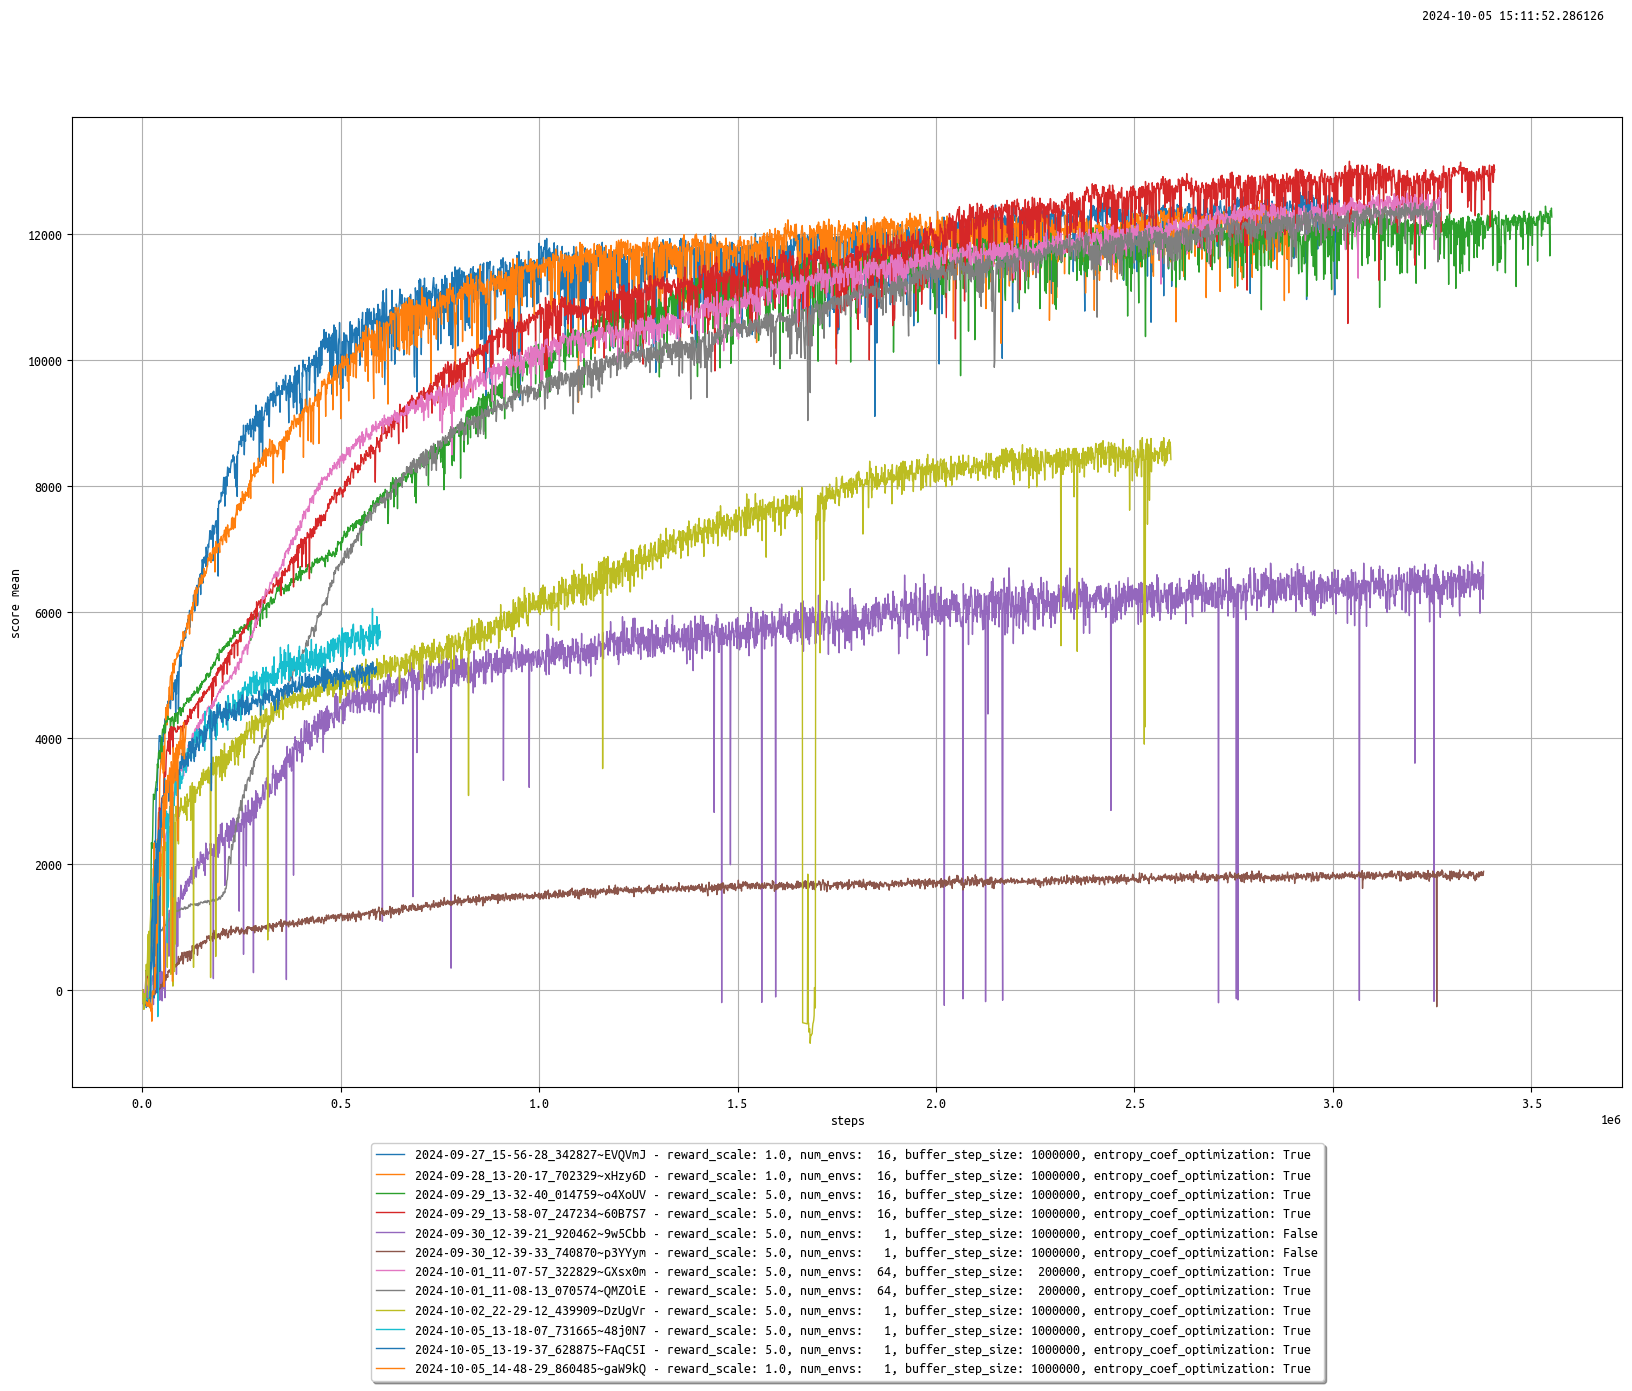

In [9]:

la = LogAnalyzer()
la.load_log_folder(
    'experiment_logs/HalfCheetah-v4/sac/',
    log_filter=lambda log: '__default' in log['logs_by_category']
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Ubuntu Mono"]
fig: plt.Figure
ax: plt.Axes
fig, ax = plt.subplots(figsize=(20, 14))

fig.text(.8, .95, get_current_timestamp())

def get_label(log: ExperimentLog):
    values = {
        'reward_scale': log['hyper_parameters']['buffer']['reward_scale'],
        'num_envs': f"{log['hyper_parameters']['num_envs']:3d}",
        'buffer_step_size': f"{log['hyper_parameters']['buffer']['step_size']:7d}",
        'entropy_coef_optimization': log['hyper_parameters']['entropy_coef'] == 'dynamic'
    }
    
    return f"{log['experiment_id']} - {', '.join([f'{k}: {v}' for k, v in values.items()])}"

ax.grid()
ax.set(xlabel='steps', ylabel='score mean')
la.plot_logs(
    lambda item: item['step'], 
    lambda item: item['scores']['mean'] if item['scores'] is not None else 0 ,
    ax=ax,
    get_label=get_label,
    linewidth=1,
)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.10, box.width, box.height * 0.90])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=1, fancybox=True, shadow=True)
# fig.show()

In [20]:
la = LogAnalyzer()
la.load_log_folder(
    'experiment_logs/HalfCheetah-v4/sac/',
    # log_filter=lambda log: max(item['step'] for item in get_log_items(log)) > 5e1
)

for id, diff in la.find_hyper_parameter_diffs():
    print(f'{id}:')
    print(json.dumps(diff, indent=4))
    print('\n')
    

2024-09-28_13-20-17_702329~xHzy6D:
{}


2024-09-29_13-32-40_014759~o4XoUV:
{
    "buffer": {
        "reward_scale": [
            1.0,
            5.0
        ]
    }
}


2024-09-29_13-58-07_247234~60B7S7:
{
    "buffer": {
        "reward_scale": [
            1.0,
            5.0
        ]
    }
}


2024-09-30_12-39-21_920462~9w5Cbb:
{
    "entropy_coef_optimizer": [
        {
            "_type": "Adam",
            "_type_fq": "torch.optim.adam.Adam",
            "...": "..."
        },
        null
    ],
    "env_specs": [
        {
            "_count": [
                16,
                1
            ]
        }
    ],
    "buffer": {
        "reward_scale": [
            1.0,
            5.0
        ],
        "total_size": [
            16000000,
            1000000
        ],
        "num_envs": [
            16,
            1
        ]
    },
    "entropy_coef": [
        "dynamic",
        1.0
    ],
    "num_envs": [
        16,
        1
    ]
}


2024-09-30_12-39-33

In [14]:
from matplotlib.patches import Patch
la = LogAnalyzer()
la.load_log_folder(
    'experiment_logs/HalfCheetah-v4/sac/',
    log_filter=lambda log: '__default' in log['logs_by_category']
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Courier New"]
fig: plt.Figure
ax: plt.Axes
fig, ax = plt.subplots(figsize=(12, 11))

fig.text(.8, .95, get_current_timestamp())

def get_log_group(log: ExperimentLog):
    values = {
        'reward_scale': log['hyper_parameters']['buffer']['reward_scale'],
        'num_envs': f"{log['hyper_parameters']['num_envs']:3d}",
        'buffer_step_size': f"{log['hyper_parameters']['buffer']['step_size']:7d}",
        'entropy_coef_optimization': log['hyper_parameters']['entropy_coef'] == 'dynamic',
        'warmup_steps': log['hyper_parameters']['warmup_steps'],
    }
    
    return ', '.join([f'{k}: {v}' for k, v in values.items()])

ax.grid()
ax.set(xlabel='steps', ylabel='score mean')
la.plot_logs_grouped(
    lambda item: item['step'], 
    lambda item: item['scores']['mean'] if item['scores'] is not None else 0 ,
    get_log_group=get_log_group,
    filter_log=lambda log: log['hyper_parameters']['warmup_steps'] == 10000, #  and log['logs_by_category']['__default'][-1]['step'] > 1e6,
    ax=ax,
    plot_individual=True,
    mean_plot_kwargs={
        'linewidth': 0.0,
        'moving_average_window_size': 20,
        'moving_average_plot_kwargs': {
            'linewidth': 0.0
        }
    },
    fill_plot_kwargs={'alpha': 0},
    individual_plot_kwargs={
        'linewidth': 0.5, 
    },
)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.10, box.width, box.height * 0.90])

handles, labels = plt.gca().get_legend_handles_labels()

new_handles = [
    Patch(facecolor=handle.get_color(), label=label)
    for handle, label in zip(handles, labels, strict=True)
]

ax.legend(handles=new_handles, 
           handlelength=0.8, handleheight=0.8, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=1, fancybox=True, shadow=True)
# fig.show()

<IPython.core.display.Javascript object>

In [20]:
from matplotlib.patches import Patch

la = LogAnalyzer()
la.load_log_folder(
    'experiment_logs/HalfCheetah-v4/sac/',
    log_filter=lambda log: '__default' in log['logs_by_category']
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Ubuntu Mono"]
fig: plt.Figure
ax: plt.Axes
fig, ax = plt.subplots(figsize=(12, 12))

fig.text(.8, .95, get_current_timestamp())

y_key = 'entropy_coef'
ax.grid()
ax.set(xlabel='steps', ylabel=f'{y_key} mean')
la.plot_logs_grouped(
    lambda item: item['step'], 
    lambda item: item[y_key]['mean'],
    get_log_group=get_log_group,
    filter_log=lambda log: log['hyper_parameters']['warmup_steps'] == 10000, #  and log['logs_by_category']['__default'][-1]['step'] > 1e6,
    ax=ax,
    plot_individual=True,
    mean_plot_kwargs={
        'linewidth': 0.0,
        'moving_average_window_size': 10,
        'moving_average_plot_kwargs': {
        }
    },
    fill_plot_kwargs={'alpha': 0},
    individual_plot_kwargs={
        'linewidth': 0.5, 
    },
)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.10, box.width, box.height * 0.90])

handles, labels = plt.gca().get_legend_handles_labels()

new_handles = [
    Patch(facecolor=handle.get_color(), label=label)
    for handle, label in zip(handles, labels, strict=True)
]

ax.legend(handles=new_handles, 
           handlelength=0.8, handleheight=0.8, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=1, fancybox=True, shadow=True)
# fig.show()

<IPython.core.display.Javascript object>

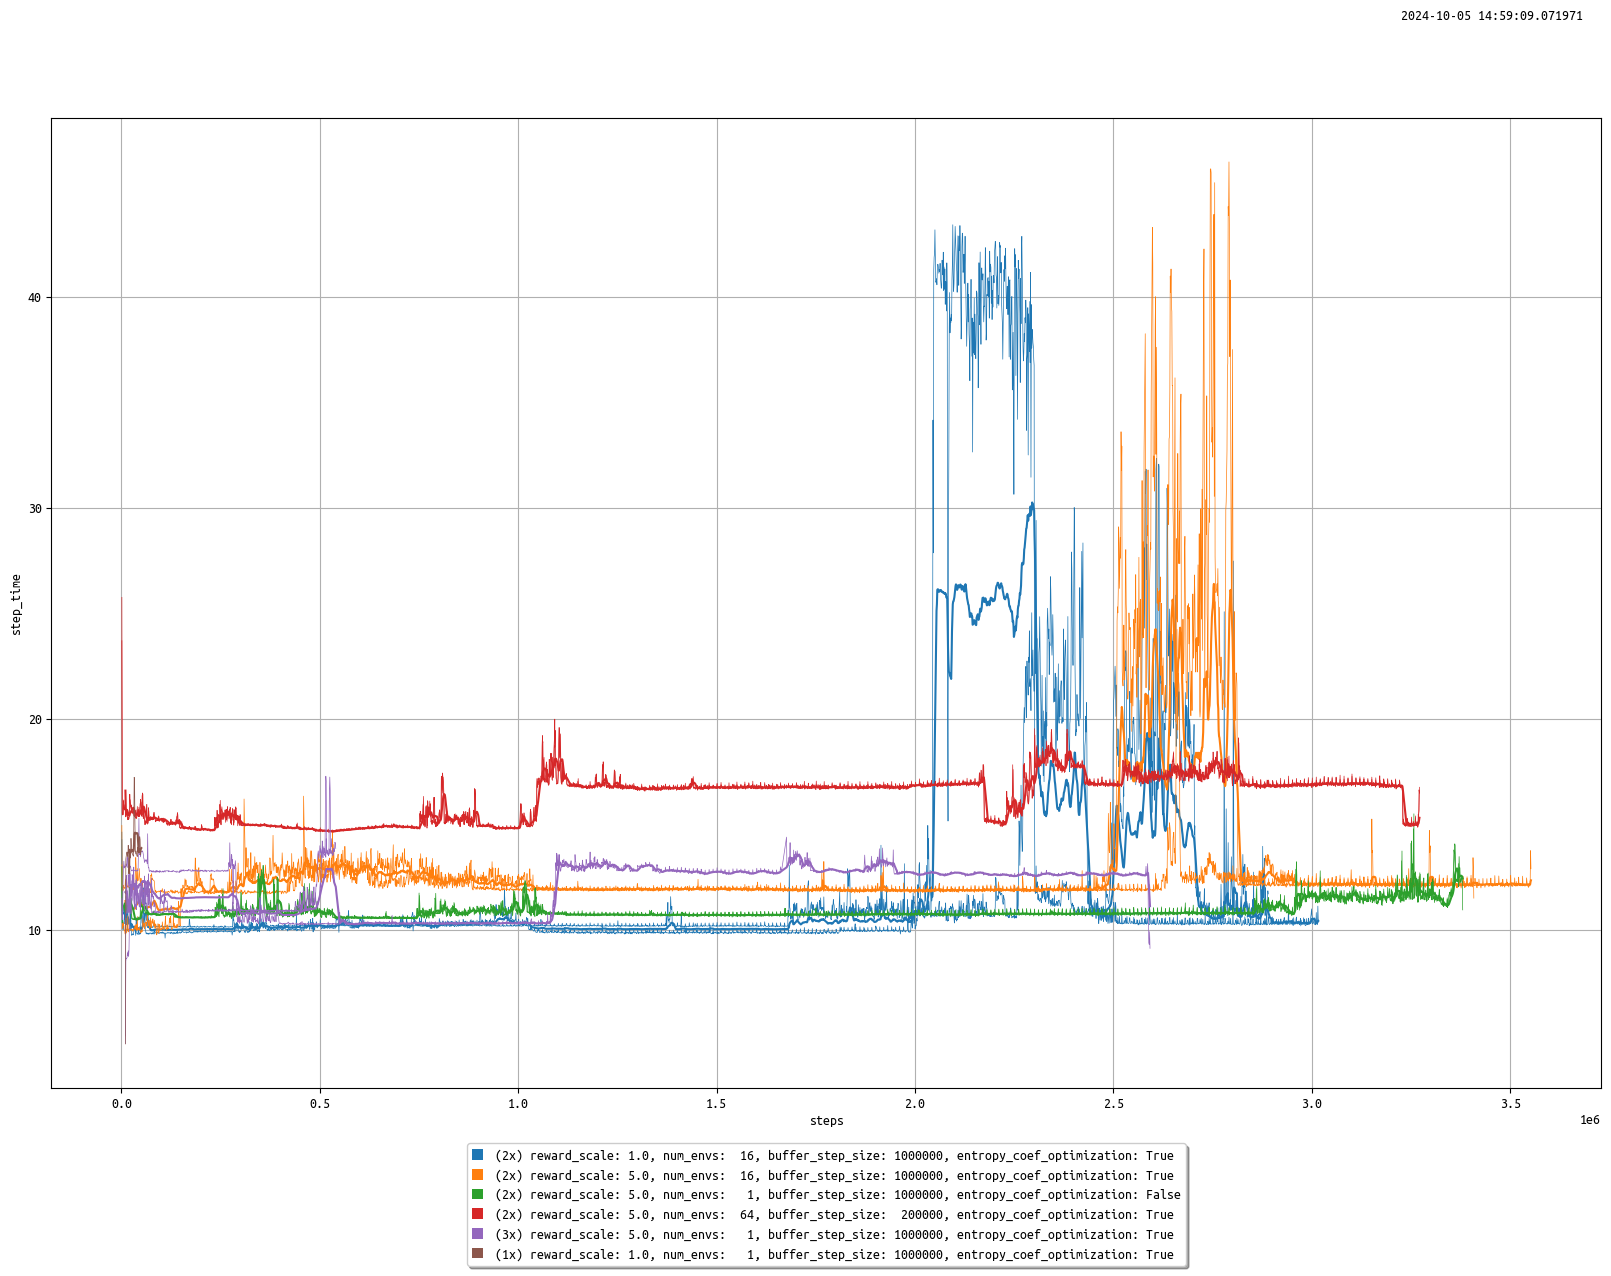

In [8]:
from matplotlib.patches import Patch

la = LogAnalyzer()
la.load_log_folder(
    'experiment_logs/HalfCheetah-v4/sac/',
    log_filter=lambda log: '__default' in log['logs_by_category']
)

plt.rcParams["font.family"] = "monospace"
plt.rcParams["font.monospace"] = ["Ubuntu Mono"]
fig: plt.Figure
ax: plt.Axes
fig, ax = plt.subplots(figsize=(20, 14))

fig.text(.8, .95, get_current_timestamp())

def get_log_group(log: ExperimentLog):
    values = {
        'reward_scale': log['hyper_parameters']['buffer']['reward_scale'],
        'num_envs': f"{log['hyper_parameters']['num_envs']:3d}",
        'buffer_step_size': f"{log['hyper_parameters']['buffer']['step_size']:7d}",
        'entropy_coef_optimization': log['hyper_parameters']['entropy_coef'] == 'dynamic'
    }
    
    return ', '.join([f'{k}: {v}' for k, v in values.items()])

y_key = 'step_time'
ax.grid()
ax.set(xlabel='steps', ylabel=f'{y_key}')
la.plot_logs_grouped(
    lambda item: item['step'], 
    lambda item: item[y_key],
    get_log_group=get_log_group,
    ax=ax,
    plot_individual=True,
    mean_plot_kwargs={
        'linewidth': 0.0,
        'moving_average_window_size': 10,
        'moving_average_plot_kwargs': {
        }
    },
    fill_plot_kwargs={'alpha': 0},
    individual_plot_kwargs={
        'linewidth': 0.5, 
    },
)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.10, box.width, box.height * 0.90])

handles, labels = plt.gca().get_legend_handles_labels()

new_handles = [
    Patch(facecolor=handle.get_color(), label=label)
    for handle, label in zip(handles, labels, strict=True)
]

ax.legend(handles=new_handles, 
           handlelength=0.8, handleheight=0.8, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=1, fancybox=True, shadow=True)
# fig.show()

In [24]:
from matplotlib.lines import Line2D
import re
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
line2d: Optional[Line2D] = None
prev_label = None

for data_file in glob.glob('experiment_logs/HalfCheetah-v4/sac_sb3/*.txt'):

    # Initialize variables
    entries = []
    current_entry = {}
    in_entry = False

    with open(data_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('---'):
                # Toggle the in_entry flag
                if in_entry:
                    # We're ending an entry
                    entries.append(current_entry)
                    current_entry = {}
                in_entry = not in_entry
            elif in_entry:
                # We're inside an entry
                if line.startswith('|'):
                    # Remove leading and trailing '|', then split by '|'
                    parts = [part.strip() for part in line.strip('|').split('|')]
                    if len(parts) >= 2:
                        key = parts[0]
                        value = parts[1]
                        if key == 'total_timesteps':
                            current_entry['total_timesteps'] = int(value)
                        if key == 'n_updates':
                            current_entry['n_updates'] = int(value)
                        elif key == 'ep_rew_mean':
                            current_entry['ep_rew_mean'] = float(value)

    # # Print the extracted data
    # for idx, entry in enumerate(entries, start=1):
    #     n_updates = entry.get('n_updates', 'N/A')
    #     ep_rew_mean = entry.get('ep_rew_mean', 'N/A')
    #     print(f"Entry {idx}: n_updates = {n_updates}, ep_rew_mean = {ep_rew_mean}")
    
    label = f'num_envs = {16 if "envs=16" in data_file else 1}'

    has_reward_scale = "reward_scale=5" in data_file
    label += f', reward_scale = {5 if has_reward_scale else 1}'
    
    label += f', learning_starts = {10000 if "learning_starts=10000" in data_file else 100}'
    
    label += f', seed = {None if "seed=594371" not in data_file else 594371}'
    
    entries = [entry for entry in entries if 'n_updates' in entry and entry['n_updates'] < 1_500_000]
    
    if 'envs=16' in data_file:
        continue
    
    plot_kwargs = {
        'linewidth': 0.99
    }
    if prev_label == label:
        line2d = ax.plot(
            [entry['n_updates'] if 'n_updates' in entry else 0 for entry in entries],
            [entry['ep_rew_mean'] / (5 if has_reward_scale else 1) for entry in entries],
            color=line2d.get_color(),
            **plot_kwargs
        )[0]
    else:
        line2d = ax.plot(
            [entry['n_updates'] if 'n_updates' in entry else 0 for entry in entries],
            [entry['ep_rew_mean'] / (5 if has_reward_scale else 1) for entry in entries],
            label=label,
            **plot_kwargs
        )[0]
    
    prev_label = label

ax.set_xticks([_ * 250000 for _ in range(7)])
ax.grid(True)
ax.legend(loc='lower right', fancybox=True)


<IPython.core.display.Javascript object>

In [5]:
from collections import defaultdict
from matplotlib.lines import Line2D
import re
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
line2d: Optional[Line2D] = None

entries_by_label: defaultdict[str, list[list[dict]]] = defaultdict(lambda: [])

for data_file in glob.glob('experiment_logs/HalfCheetah-v4/sac_sb3/*.txt'):

    # Initialize variables
    entries = []
    current_entry = {}
    in_entry = False

    with open(data_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('---'):
                # Toggle the in_entry flag
                if in_entry:
                    # We're ending an entry
                    entries.append(current_entry)
                    current_entry = {}
                in_entry = not in_entry
            elif in_entry:
                # We're inside an entry
                if line.startswith('|'):
                    # Remove leading and trailing '|', then split by '|'
                    parts = [part.strip() for part in line.strip('|').split('|')]
                    if len(parts) >= 2:
                        key = parts[0]
                        value = parts[1]
                        if key == 'total_timesteps':
                            current_entry['total_timesteps'] = int(value)
                        if key == 'n_updates':
                            current_entry['n_updates'] = int(value)
                        elif key == 'ep_rew_mean':
                            current_entry['ep_rew_mean'] = float(value)

    # # Print the extracted data
    # for idx, entry in enumerate(entries, start=1):
    #     n_updates = entry.get('n_updates', 'N/A')
    #     ep_rew_mean = entry.get('ep_rew_mean', 'N/A')
    #     print(f"Entry {idx}: n_updates = {n_updates}, ep_rew_mean = {ep_rew_mean}")
    
    label = f'num_envs = {16 if "envs=16" in data_file else 1}'

    has_reward_scale = "reward_scale=5" in data_file
    label += f', reward_scale = {5 if has_reward_scale else 1}'
    
    label += f', learning_starts = {10000 if "learning_starts=10000" in data_file else 100}'
    
    label += f', sws = {1 if "sws=1" in data_file else 100}'
    
    # label += f', seed = {None if "seed=594371" not in data_file else 594371}'
    
    entries = [entry for entry in entries if 'n_updates' in entry and entry['n_updates'] < 1_500_000]
    
    if 'envs=16' in data_file or 'seed' in data_file:
        continue
    
    if 'learning_starts = 10000' not in label:
        continue
    
    entries_by_label[label].append(entries)
    

for label, entries_list in sorted(entries_by_label.items(), key=lambda le: le[0]):
    plot_kwargs = {
        'linewidth': 0.99
    }
    line2d = ax.plot(
        [entry['n_updates'] if 'n_updates' in entry else 0 for entry in entries_list[0]],
        [entry['ep_rew_mean'] / (5 if 'reward_scale = 5' in label else 1) for entry in entries_list[0]],
        label=f'({len(entries_list)}x) {label}',
        **plot_kwargs
    )[0]
    for entries in entries_list[1:]:
        ax.plot(
            [entry['n_updates'] if 'n_updates' in entry else 0 for entry in entries],
            [entry['ep_rew_mean'] / (5 if 'reward_scale = 5' in label else 1) for entry in entries],
            color=line2d.get_color(),
            **plot_kwargs
        )


ax.set_xticks([_ * 250000 for _ in range(7)])
ax.grid(True)
ax.legend(loc='lower right', fancybox=True)


<IPython.core.display.Javascript object>

In [18]:
from collections import defaultdict
from matplotlib.lines import Line2D
import re
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
line2d: Optional[Line2D] = None

entries_by_label: defaultdict[str, list[list[dict]]] = defaultdict(lambda: [])

for data_file in glob.glob('experiment_logs/HalfCheetah-v4/sac_sb3/*.txt'):

    # Initialize variables
    entries = []
    current_entry = {}
    in_entry = False

    with open(data_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('---'):
                # Toggle the in_entry flag
                if in_entry:
                    # We're ending an entry
                    entries.append(current_entry)
                    current_entry = {}
                in_entry = not in_entry
            elif in_entry:
                # We're inside an entry
                if line.startswith('|'):
                    # Remove leading and trailing '|', then split by '|'
                    parts = [part.strip() for part in line.strip('|').split('|')]
                    if len(parts) >= 2:
                        key = parts[0]
                        value = parts[1]
                        if key == 'total_timesteps':
                            current_entry['total_timesteps'] = int(value)
                        elif key == 'n_updates':
                            current_entry['n_updates'] = int(value)
                        elif key == 'ep_rew_mean':
                            current_entry['ep_rew_mean'] = float(value)
                        elif key == 'ent_coef':
                            current_entry['ent_coef'] = float(value)

    # # Print the extracted data
    # for idx, entry in enumerate(entries, start=1):
    #     n_updates = entry.get('n_updates', 'N/A')
    #     ep_rew_mean = entry.get('ep_rew_mean', 'N/A')
    #     print(f"Entry {idx}: n_updates = {n_updates}, ep_rew_mean = {ep_rew_mean}")
    
    label = f'num_envs = {16 if "envs=16" in data_file else 1}'

    has_reward_scale = "reward_scale=5" in data_file
    label += f', reward_scale = {5 if has_reward_scale else 1}'
    
    label += f', learning_starts = {10000 if "learning_starts=10000" in data_file else 100}'
    
    label += f', sws = {1 if "sws=1" in data_file else 100}'
    
    # label += f', seed = {None if "seed=594371" not in data_file else 594371}'
    
    entries = [entry for entry in entries if 'n_updates' in entry and entry['n_updates'] < 1_500_000]
    
    if 'envs=16' in data_file or 'seed' in data_file:
        continue
    
    if 'learning_starts = 10000' not in label:
        continue
    
    entries_by_label[label].append(entries)
    

for label, entries_list in sorted(entries_by_label.items(), key=lambda le: le[0]):
    plot_kwargs = {
        'linewidth': 0.99
    }
    
    line2d = ax.plot(
        [entry['n_updates'] if 'n_updates' in entry else 0 for entry in entries_list[0]],
        [entry['ent_coef'] for entry in entries_list[0]],
        label=f'({len(entries_list)}x) {label}',
        **plot_kwargs
    )[0]
    for entries in entries_list[1:]:
        ax.plot(
            [entry['n_updates'] if 'n_updates' in entry else 0 for entry in entries],
            [entry['ent_coef'] for entry in entries],
            color=line2d.get_color(),
            **plot_kwargs
        )


ax.set_xticks([_ * 250000 for _ in range(7)])
ax.grid(True)
ax.legend(loc='lower right', fancybox=True)


<IPython.core.display.Javascript object>

In [15]:
import plotly.express as px
import pandas as pd

df = pd.DataFrame(
    data=[
        [1, 1, 'one'],
        [2, 7, 'one'],
        [3, 9, 'one'],
        [1, 2, 'one'],
        [2, 2, 'one'],
        [3, 2, 'one'],
        [1, 1, 'two'],
        [2, 4, 'two'],
        [3, 6, 'two'],
    ],
    columns=['x', 'y', 'cat']
)
px.line(df, x='x', y='y', color='cat')

In [23]:
import plotly.graph_objects as go

fig = go.Figure()
x = go.Scatter(
    x=[1, 2, 3],
    y=[2, 2, 2],
    name='one'
)
x = fig.add_trace(x)

fig.add_trace(go.Scatter(
    x=[1, 2, 3],
    y=[1, 4, 9],
    name='two'
))

fig.show()

{'data': [{'name': 'one', 'x': [1, 2, 3], 'y': [2, 2, 2], 'type': 'scatter'},
  {'name': 'two', 'x': [1, 2, 3], 'y': [1, 4, 9], 'type': 'scatter'}],
 'layout': {'template': {'data': {'histogram2dcontour': [{'type': 'histogram2dcontour',
      'colorbar': {'outlinewidth': 0, 'ticks': ''},
      'colorscale': [[0.0, '#0d0887'],
       [0.1111111111111111, '#46039f'],
       [0.2222222222222222, '#7201a8'],
       [0.3333333333333333, '#9c179e'],
       [0.4444444444444444, '#bd3786'],
       [0.5555555555555556, '#d8576b'],
       [0.6666666666666666, '#ed7953'],
       [0.7777777777777778, '#fb9f3a'],
       [0.8888888888888888, '#fdca26'],
       [1.0, '#f0f921']]}],
    'choropleth': [{'type': 'choropleth',
      'colorbar': {'outlinewidth': 0, 'ticks': ''}}],
    'histogram2d': [{'type': 'histogram2d',
      'colorbar': {'outlinewidth': 0, 'ticks': ''},
      'colorscale': [[0.0, '#0d0887'],
       [0.1111111111111111, '#46039f'],
       [0.2222222222222222, '#7201a8'],
       [0.333